In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import special


import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:


input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
#input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1b-mediumbad'


#input_dir = 'bootstrap-toy-study8a-1d-1d-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-1d-goodres'
#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'
#input_dir = 'bootstrap-toy-study8a-1d-1d-mediumbad'






#input_dir = 'bootstrap-toy-study8a-1d-2a-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-2a-nominal-resolution'


#input_dir = 'bootstrap-toy-study8a-1d-2a'



#hist_nbins = 10
hist_nbins = 20
#hist_nbins = 40


#fitType = 'bin center approximation'
fitType = 'integral within bin'




hist_xlow = -3.
hist_xhigh = 3.

#hist_xlow = -2.
#hist_xhigh = 2.




with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (100000, 1)
 shape of true_pts:   (10000, 1)





In [3]:


with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)

main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

print('\n\n')
print(' shape of main_sample_omnifold_weights: %s' % str(main_sample_omnifold_weights.shape))
print('\n\n')





 shape of main_sample_omnifold_weights: (100000,)





In [4]:
main_sample_omnifold_weights

array([0.076027  , 0.11945848, 0.07986826, ..., 0.07809694, 0.10657342,
       0.08067343])

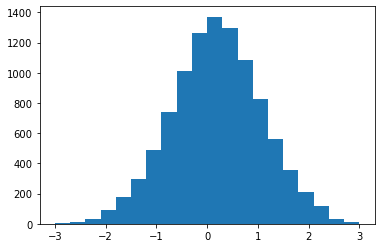

In [5]:
unfolded_hist,hist_bin_edges,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )

In [6]:
hist_bin_edges

array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
        0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ])

In [7]:
hist_bin_centers = np.zeros( hist_nbins )
for bi in range(hist_nbins) :
    hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])

In [8]:
hist_bin_centers

array([-2.85, -2.55, -2.25, -1.95, -1.65, -1.35, -1.05, -0.75, -0.45,
       -0.15,  0.15,  0.45,  0.75,  1.05,  1.35,  1.65,  1.95,  2.25,
        2.55,  2.85])

In [9]:
bin_width = hist_bin_edges[1] - hist_bin_edges[0]

In [10]:
weight_sum = np.sum( main_sample_omnifold_weights )
print('\n\n Sum of ominfold weights:  %.3f' % weight_sum )



 Sum of ominfold weights:  10007.449


In [11]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [12]:
mean_cov = calc_mean_cov( main_sample_omnifold_weights, 0, 0 )

In [13]:
mean_cov

{'mean_x1': 0.19259512011258573,
 'mean_x2': 0.19259512011258573,
 'cov_x1x2': 0.8091937715984086,
 'rms1': 0.8995519838221738}

In [14]:
dummy_weights = np.ones( len(train_pts))
dummy_weights = (len(true_pts) / len(train_pts)) * dummy_weights

In [15]:
dummy_weights

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [16]:
dummy_weights.shape

(100000,)

<function matplotlib.pyplot.show(close=None, block=None)>

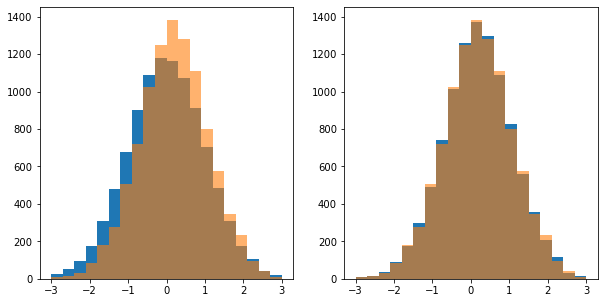

In [17]:
fig,ax = plt.subplots( 1, 2, figsize=(2*5,5))

ax[0].hist( train_pts[:,0], bins=hist_nbins, weights=dummy_weights, range=[hist_xlow, hist_xhigh] )
ax[0].hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh], alpha=0.6 )

ax[1].hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )
ax[1].hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh], alpha=0.6 )

plt.show

In [18]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 500 bootstrap samples.




 boot   0 weights: [0.07695288 0.1132453  0.08179921 ... 0.07942    0.10224509 0.08250124]
 boot   1 weights: [0.08055853 0.11210515 0.08394099 ... 0.08257134 0.10290539 0.08451173]
 boot   2 weights: [0.07999077 0.11628034 0.08371986 ... 0.08207489 0.10547522 0.08438919]
 boot   3 weights: [0.08027876 0.11576523 0.08377686 ... 0.08211724 0.10121322 0.0844365 ]
 boot   4 weights: [0.07477299 0.11180621 0.07925264 ... 0.07705891 0.10576773 0.08033731]
 boot   5 weights: [0.07923957 0.11295059 0.08294659 ... 0.08140637 0.10302028 0.08324765]
 boot   6 weights: [0.07714214 0.11666945 0.08232594 ... 0.08014552 0.10377636 0.08301067]
 boot   7 weights: [0.07330201 0.11546022 0.07701526 ... 0.07513315 0.10464071 0.07803981]
 boot   8 weights: [0.07675822 0.11600061 0.08062763 ... 0.07866804 0.10756853 0.08152186]
 boot   9 weights: [0.079258   0.11812854 0.08236963 ... 0.08063176 0.10502454 0.08294515]
 boot  10 weights: [0.07814099 0.11728006 0.08081186 ... 0.07972989 0.10543773 0.08135177]

 boot 110 weights: [0.08101204 0.11547151 0.08386875 ... 0.08279952 0.10285956 0.08427433]
 boot 111 weights: [0.07872565 0.11236757 0.08077487 ... 0.08003085 0.09905087 0.08111141]
 boot 112 weights: [0.07533454 0.11730434 0.07730869 ... 0.07595254 0.10970689 0.07787318]
 boot 113 weights: [0.07886784 0.11520795 0.08115148 ... 0.08008268 0.10357285 0.0816112 ]
 boot 114 weights: [0.0801466  0.11213526 0.08556041 ... 0.08311572 0.10081412 0.08631036]
 boot 115 weights: [0.07978411 0.1154743  0.0828729  ... 0.08131066 0.10431709 0.08335   ]
 boot 116 weights: [0.07743161 0.1121858  0.08306192 ... 0.08017102 0.10543743 0.0841688 ]
 boot 117 weights: [0.07805223 0.11342115 0.08506068 ... 0.08093972 0.10032741 0.08658023]
 boot 118 weights: [0.07635103 0.11753433 0.08060966 ... 0.07850103 0.1051322  0.08120223]
 boot 119 weights: [0.07553437 0.11477332 0.07964858 ... 0.0772778  0.10310143 0.08047598]
 boot 120 weights: [0.07430769 0.11406741 0.07941562 ... 0.07705235 0.10665223 0.08023103]

 boot 215 weights: [0.07719829 0.11566783 0.07925603 ... 0.07843146 0.11027247 0.07958555]
 boot 216 weights: [0.07990771 0.11574066 0.08029716 ... 0.07997651 0.1088986  0.08026898]
 boot 217 weights: [0.08247094 0.11194523 0.08543661 ... 0.08440872 0.10039069 0.08602054]
 boot 218 weights: [0.08083842 0.11221237 0.0829694  ... 0.08205339 0.10249112 0.08331345]
 boot 219 weights: [0.07830326 0.11662867 0.08338407 ... 0.08103076 0.10460487 0.08388783]
 boot 220 weights: [0.07475088 0.11438237 0.07777975 ... 0.07572837 0.10213908 0.07860924]
 boot 221 weights: [0.07780695 0.11359532 0.08250331 ... 0.08043682 0.10317954 0.08327689]
 boot 222 weights: [0.08092252 0.11395847 0.08158869 ... 0.081234   0.10420219 0.08187644]
 boot 223 weights: [0.07736621 0.11490782 0.08174218 ... 0.07929232 0.10147147 0.08269601]
 boot 224 weights: [0.07924046 0.11523408 0.0820976  ... 0.08099578 0.10358699 0.08253134]
 boot 225 weights: [0.07730546 0.11520725 0.08206543 ... 0.07987616 0.10550599 0.08266908]

 boot 316 weights: [0.07662854 0.11377111 0.08216344 ... 0.07951892 0.10649777 0.08300231]
 boot 317 weights: [0.07964352 0.11404896 0.08267738 ... 0.0807701  0.10653196 0.08329234]
 boot 318 weights: [0.07492299 0.11793517 0.07848561 ... 0.0764768  0.10690164 0.07942366]
 boot 319 weights: [0.08017206 0.11197613 0.08524139 ... 0.08243836 0.10063267 0.08591435]
 boot 320 weights: [0.07817927 0.1162842  0.08136254 ... 0.07994198 0.10616931 0.08147317]
 boot 321 weights: [0.07675612 0.11588881 0.0825833  ... 0.07931173 0.10382555 0.0837833 ]
 boot 322 weights: [0.07874712 0.11676145 0.0803693  ... 0.0792925  0.10419762 0.0808956 ]
 boot 323 weights: [0.07734694 0.11652037 0.07959772 ... 0.07834135 0.10738749 0.07987929]
 boot 324 weights: [0.08438179 0.11628806 0.08322224 ... 0.08365229 0.10451868 0.08329719]
 boot 325 weights: [0.07720459 0.11410193 0.083332   ... 0.08028065 0.10801767 0.08451952]
 boot 326 weights: [0.07509509 0.11589215 0.07913425 ... 0.07746131 0.10508127 0.07996456]

 boot 423 weights: [0.07959463 0.11494247 0.084016   ... 0.08172581 0.10033051 0.08481236]
 boot 424 weights: [0.0809741  0.11527486 0.08376952 ... 0.08227017 0.1061951  0.08414361]
 boot 425 weights: [0.07823919 0.11675071 0.08347129 ... 0.08078686 0.10090735 0.08406868]
 boot 426 weights: [0.075695   0.11622238 0.07942857 ... 0.07703381 0.10629324 0.08034538]
 boot 427 weights: [0.08272426 0.11421671 0.08397085 ... 0.08363643 0.10604615 0.08405242]
 boot 428 weights: [0.08019515 0.11469668 0.08426963 ... 0.08224827 0.10258894 0.08502846]
 boot 429 weights: [0.07863264 0.1123573  0.08315992 ... 0.08050314 0.10527656 0.08398289]
 boot 430 weights: [0.08027448 0.1155928  0.08384261 ... 0.0818581  0.1065693  0.08479815]
 boot 431 weights: [0.07790093 0.11501645 0.08041965 ... 0.07896201 0.10715655 0.08096049]
 boot 432 weights: [0.07873527 0.11654494 0.08279208 ... 0.08066514 0.10413146 0.08351222]
 boot 433 weights: [0.07719345 0.1127868  0.07975815 ... 0.07844946 0.10663429 0.08047985]

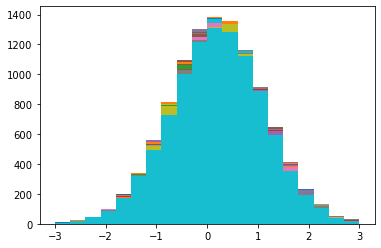

In [19]:
boot_hist_content = np.zeros( shape=(n_samples, hist_nbins))


simple_calc_mean = np.zeros( n_samples )
simple_calc_cov  = np.zeros( n_samples )


for bi in range(n_samples) :
    
    #boot_hist_content.append()
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)
    
    if not exists(fname) :  
        print('\n\n *** Missing %s' % fname )
        continue
        
    with open(fname,'rb') as f :
            
        final_push_weights_scaled = np.load(f)
        print(' boot %3d weights: ' % bi, end='')
        print( final_push_weights_scaled)
    
        hist_content,_,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=final_push_weights_scaled, range=[hist_xlow, hist_xhigh] )
        #print(hist_content)
        boot_hist_content[bi,:] = hist_content
        
        
        mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )
        
        simple_calc_mean[bi] = mean_cov['mean_x1']
        simple_calc_cov[bi]  = mean_cov['cov_x1x2']
    

In [20]:
boot_hist_content

array([[  4.73511873,  12.07558147,  36.23469459, ..., 123.24465832,
         46.04093713,  17.53543536],
       [  2.34833645,  14.18617298,  39.69039427, ..., 112.5414572 ,
         38.65251413,  14.88927542],
       [  5.34649299,  13.65937763,  31.2095019 , ..., 114.33198717,
         37.13522409,  15.19253065],
       ...,
       [  6.65845759,  15.0637594 ,  26.47299375, ..., 117.9602284 ,
         40.54259478,  14.5551056 ],
       [  2.54117099,   9.4262938 ,  30.96471393, ..., 106.37586118,
         42.22364039,  21.88569142],
       [  5.17475365,  16.1953153 ,  46.88182623, ..., 105.58050309,
         36.24851391,  15.85875421]])

In [21]:
boot_hist_content[:,6]

array([491.67261641, 518.57296619, 501.71765887, 513.14676062,
       496.28311661, 504.49879222, 499.85309186, 473.66960504,
       504.21562397, 524.2378066 , 509.27764552, 503.85428587,
       536.15966461, 490.46830963, 512.73638004, 508.81318873,
       503.56846358, 504.41352028, 515.98906319, 520.73427507,
       532.01851127, 527.1450989 , 481.95447795, 505.79308734,
       468.59545258, 487.99967285, 499.89895991, 502.01840563,
       511.02352811, 521.71061422, 489.95038408, 502.66002283,
       490.24485228, 497.43393596, 514.29286919, 550.46281488,
       481.96783153, 496.64438138, 503.01473044, 525.59920619,
       492.51975023, 469.37700879, 505.90814694, 538.04818466,
       507.63763114, 481.64306813, 510.66721954, 514.69751473,
       518.38555086, 505.62836116, 512.8128054 , 514.9714478 ,
       486.84482799, 542.72976535, 501.0412909 , 482.35522682,
       492.53260984, 484.68835808, 511.44752469, 504.5906913 ,
       512.2020911 , 493.16152798, 518.02704711, 489.87

In [22]:
hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        

In [23]:
hist_corr_mat[0,hist_nbins-1] = -1.

<function matplotlib.pyplot.show(close=None, block=None)>

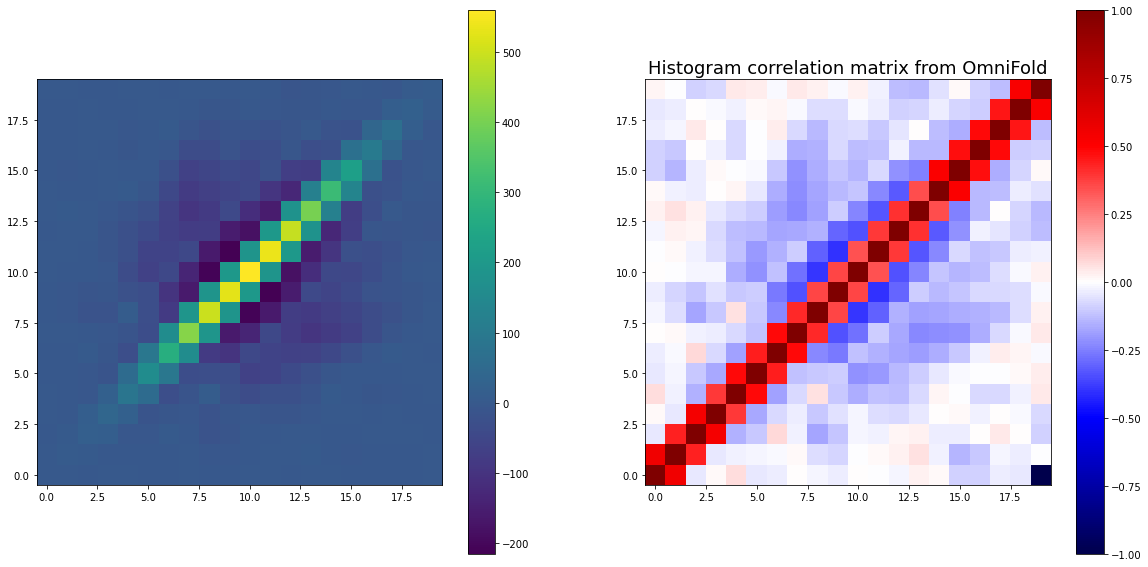

In [24]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [25]:
for bi in range(hist_nbins) :
    for bj in range(hist_nbins ) :
        
        calc_corr = hist_cov_mat[bi,bj] / np.sqrt( hist_cov_mat[bi,bi] * hist_cov_mat[bj,bj])
        
        print('  %2d, %2d :  histi  %10.2f   histj %10.2f  cov = %9.3f   cor = %9.4f  (%9.4f)' % 
              (bi, bj, boot_hist_content[0,bi], boot_hist_content[0,bj],
               hist_cov_mat[bi,bj], hist_corr_mat[bi,bj], calc_corr))



   0,  0 :  histi        4.74   histj       4.74  cov =     2.493   cor =    1.0000  (   1.0000)
   0,  1 :  histi        4.74   histj      12.08  cov =     2.415   cor =    0.5508  (   0.5508)
   0,  2 :  histi        4.74   histj      36.23  cov =    -0.322   cor =   -0.0457  (  -0.0457)
   0,  3 :  histi        4.74   histj      88.48  cov =     0.148   cor =    0.0147  (   0.0147)
   0,  4 :  histi        4.74   histj     180.62  cov =     0.915   cor =    0.0625  (   0.0625)
   0,  5 :  histi        4.74   histj     305.81  cov =    -0.847   cor =   -0.0420  (  -0.0420)
   0,  6 :  histi        4.74   histj     491.67  cov =    -0.835   cor =   -0.0322  (  -0.0322)
   0,  7 :  histi        4.74   histj     760.74  cov =     0.153   cor =    0.0048  (   0.0048)
   0,  8 :  histi        4.74   histj    1019.76  cov =    -0.764   cor =   -0.0217  (  -0.0217)
   0,  9 :  histi        4.74   histj    1209.20  cov =    -1.225   cor =   -0.0338  (  -0.0338)
   0, 10 :  histi        4.74 

In [26]:
print('      ', end='')
for bj in range( hist_nbins ) :
    print('   %2d   ' % bj, end='')
print()

for bi in range( hist_nbins ) :
    print(' %2d : ' % bi, end='')
    for bj in range( hist_nbins ) :
        print( ' %6.3f ' % hist_corr_mat[bi,bj], end='')
    print()

          0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19   
  0 :   1.000   0.551  -0.046   0.015   0.063  -0.042  -0.032   0.005  -0.022  -0.034   0.004  -0.001  -0.019   0.029   0.010  -0.091  -0.093  -0.033  -0.043  -1.000 
  1 :   0.551   1.000   0.437  -0.045  -0.029  -0.020  -0.010   0.012  -0.068  -0.083  -0.004   0.015   0.024   0.056  -0.026  -0.141  -0.105  -0.017  -0.033  -0.004 
  2 :  -0.046   0.437   1.000   0.536  -0.150  -0.107   0.075  -0.026  -0.173  -0.114  -0.018  -0.024   0.020   0.025  -0.034  -0.032   0.004   0.041   0.004  -0.087 
  3 :   0.015  -0.045   0.536   1.000   0.386  -0.170  -0.072  -0.038  -0.109  -0.059  -0.022  -0.065  -0.078  -0.046   0.005   0.010  -0.024   0.002  -0.013  -0.076 
  4 :   0.063  -0.029  -0.150   0.386   1.000   0.477  -0.182  -0.074   0.057  -0.106  -0.158  -0.121  -0.127  -0.072   0.021  -0.008  -0.075  -0.074  -0.024   0.044

In [27]:
cov_det = np.linalg.det( hist_cov_mat )
print('\n\n Histogram covariance matrix determinant:  %9.4f\n\n' % cov_det)



 Histogram covariance matrix determinant:  53488240511347529568936263680.0000




In [28]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
print(hist_cov_inv)

[[ 2.39195575e+00 -1.68607645e+00  2.22121111e+00 -1.67625006e+00
   1.96929137e+00 -1.32032866e+00  1.67955829e+00 -1.02427862e+00
   1.36591820e+00 -7.45449014e-01  1.10144216e+00 -4.86687544e-01
   8.64183882e-01 -2.37599516e-01  6.25614040e-01 -4.71075656e-05
   4.00392579e-01  2.59144683e-01  1.77742562e-01  4.68712485e-01]
 [-1.68607645e+00  2.21018774e+00 -2.23833192e+00  2.38793552e+00
  -2.12801034e+00  2.06830994e+00 -1.88998389e+00  1.79185575e+00
  -1.57813627e+00  1.51631936e+00 -1.31873782e+00  1.26018694e+00
  -1.07767461e+00  1.00703211e+00 -8.29846438e-01  7.84523626e-01
  -5.88866855e-01  4.79025969e-01 -3.38117696e-01  2.40099478e-01]
 [ 2.22121111e+00 -2.23833192e+00  3.01178529e+00 -2.69301170e+00
   2.88382343e+00 -2.31756344e+00  2.56228727e+00 -1.94772273e+00
   2.14511778e+00 -1.57440212e+00  1.78463935e+00 -1.21440306e+00
   1.44837228e+00 -8.56272486e-01  1.10177771e+00 -5.19885907e-01
   7.63519526e-01 -1.00666817e-01  3.95639415e-01  2.56478395e-01]
 [-1.67

In [29]:
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )
print( cov_inv_test)

[[ 1.00000000e+00 -9.87748047e-16  4.71588731e-16 -4.96683576e-17
   9.83598440e-16 -1.88108060e-16  1.95597578e-16  2.34365431e-16
   8.31682006e-16 -5.54767178e-16 -6.87970162e-16 -8.78120260e-16
  -2.23984188e-16  8.83012159e-16  7.95421811e-17  5.17450721e-16
  -6.78048977e-16 -1.21036400e-16  1.25534191e-16  8.15327249e-17]
 [-6.69197547e-14  1.00000000e+00 -9.88838966e-14  1.17612792e-13
  -1.15444254e-13  1.66293970e-13 -3.69630882e-14  1.06604128e-13
  -1.64084728e-13  1.36974939e-13 -1.17530660e-13  1.67867975e-13
  -1.14449967e-13  2.06104940e-13 -1.26741115e-13  1.35828842e-13
  -1.02425748e-13  5.82022154e-14 -6.76448262e-14  5.42870041e-14]
 [-3.98110774e-15  4.73142761e-15  1.00000000e+00  5.63050962e-15
   5.27276945e-15  3.96459862e-15 -1.04858630e-14  1.97877983e-14
  -1.30601664e-14 -5.19552875e-15  3.38906562e-15  6.91873588e-16
  -8.13459868e-15  5.98537626e-15  2.63511460e-15  1.32671122e-15
  -1.52874925e-15  2.18536525e-15  1.71258638e-15  8.83019181e-16]
 [ 7.46

<function matplotlib.pyplot.show(close=None, block=None)>

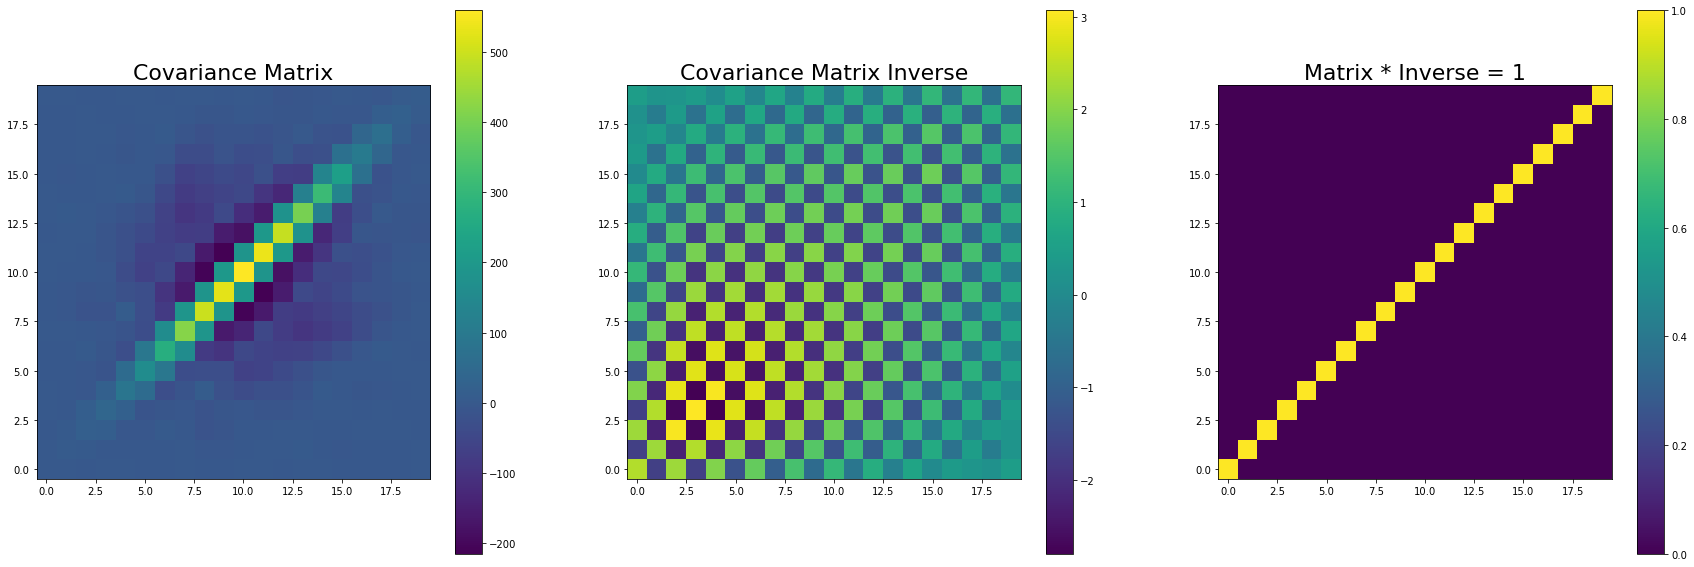

In [30]:
fig,ax = plt.subplots( 1, 3, figsize=(3*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im_covinv = ax[1].imshow(hist_cov_inv, origin='lower')
ax[1].figure.colorbar( im_covinv, ax=ax[1] )

im_covtest = ax[2].imshow(cov_inv_test, origin='lower')
ax[2].figure.colorbar( im_covtest, ax=ax[2] )

ax[0].set_title('Covariance Matrix', fontsize='22')
ax[1].set_title('Covariance Matrix Inverse', fontsize='22')
ax[2].set_title('Matrix * Inverse = 1', fontsize='22')

plt.show



(-50.0, 50.0)

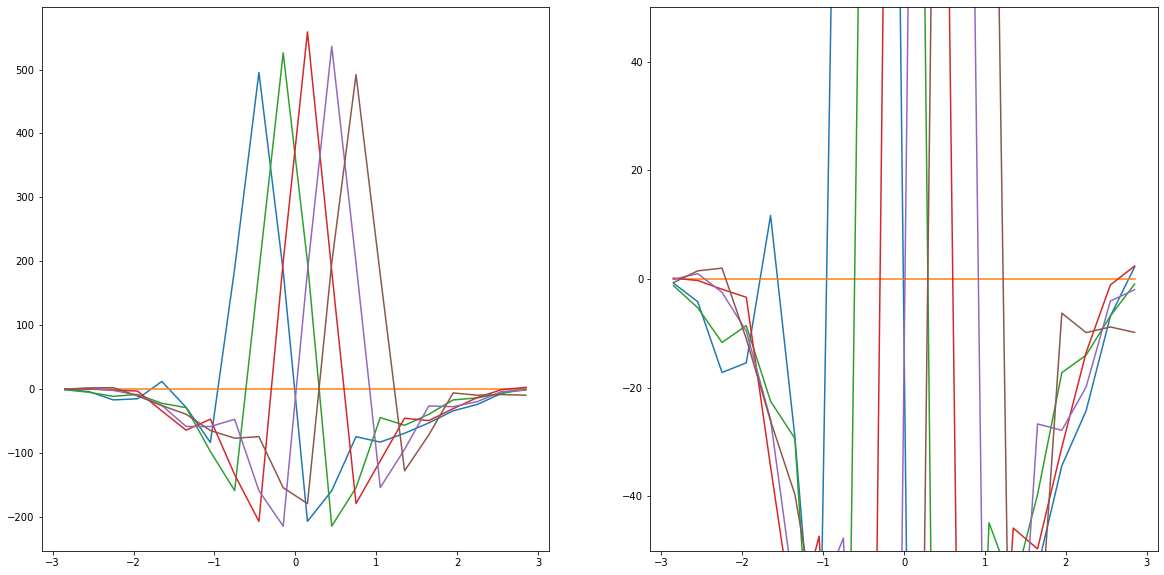

In [31]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[0].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[12,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[1].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[12,:] )


ax[1].set_ylim([-50,50])

(-50.0, 50.0)

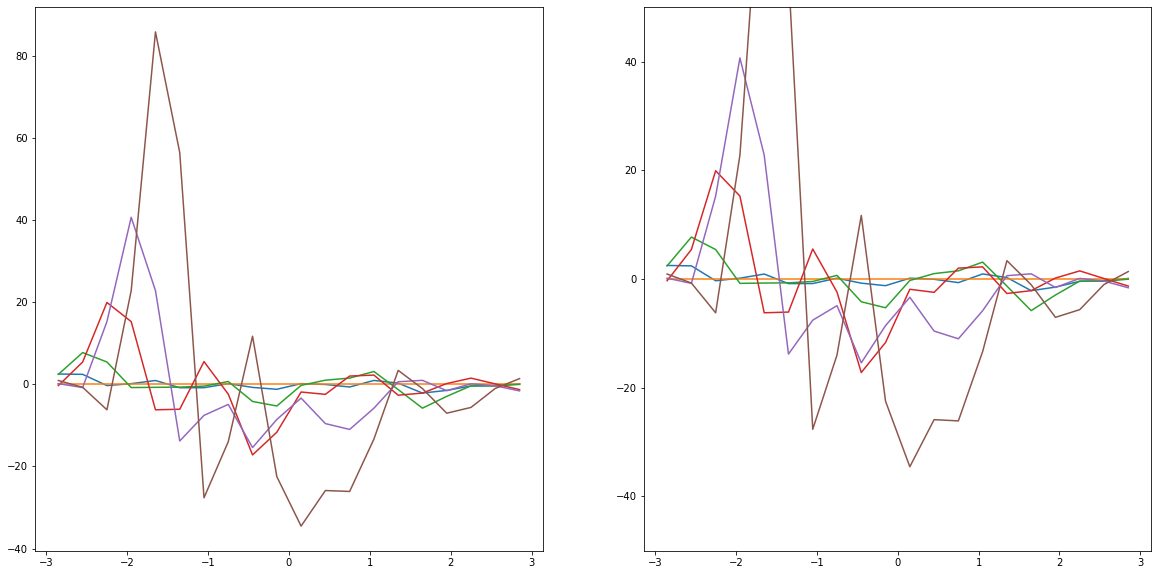

In [32]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[4,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[4,:] )


ax[1].set_ylim([-50,50])

## Try using the pseudo inverse of the covariance matrix for the chi2

In [33]:

#--- off
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat )


#--- not enough?
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.0001 )

#--- ok
hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.001 )
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.01 )

#-- probably too much
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.05 )


print(hist_cov_pinv)

[[ 0.10882404  0.02748787 -0.07623609  0.0306216  -0.040841   -0.00659569
  -0.00324585 -0.03429242  0.01542023 -0.04557195  0.01775158 -0.040503
   0.00798651 -0.02580541 -0.01361931 -0.00034331 -0.03927022  0.01740349
  -0.05816337  0.00904004]
 [ 0.02748787  0.07698913 -0.00030788 -0.02402038  0.02087561 -0.02134998
   0.01241765 -0.0092068  -0.00116324  0.00377519 -0.01202679  0.01150415
  -0.0183583   0.01435242 -0.01832765  0.01108497 -0.00480522 -0.01150028
   0.02717828 -0.04310858]
 [-0.07623609 -0.00030788  0.08197525 -0.02777812  0.02169025  0.00974035
  -0.00679286  0.02630772 -0.01477965  0.03078577 -0.01343483  0.02394302
  -0.0046486   0.0119075   0.01060325 -0.00353295  0.02531829 -0.01356709
   0.03280065 -0.01014398]
 [ 0.0306216  -0.02402038 -0.02777812  0.03903299 -0.02392696  0.00348347
   0.00107867 -0.01564541  0.01379932 -0.02258054  0.01394058 -0.01772892
   0.00708226 -0.00896472 -0.00412615  0.00243472 -0.01698386  0.01095045
  -0.02559147  0.00611868]
 [-0.0

In [34]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv

In [35]:
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

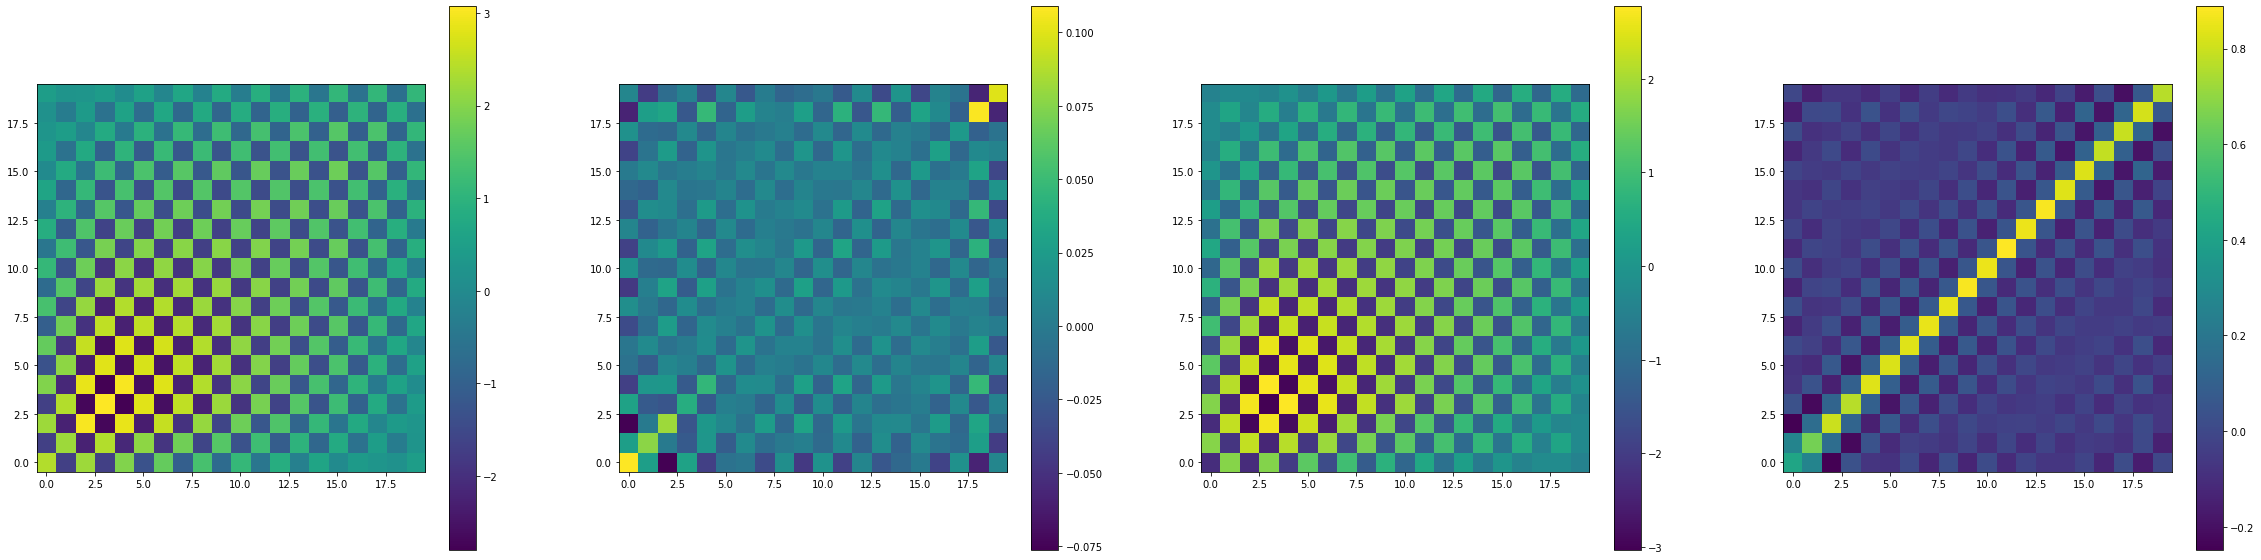

In [36]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [37]:
for bi in range( hist_nbins ) :
    for bj in range( hist_nbins ) :
        print('  %3d, %3d:   inv = %8.3f   pinv = %8.3f' % (bi, bj, hist_cov_inv[bi,bj], hist_cov_pinv[bi,bj]))

    0,   0:   inv =    2.392   pinv =    0.109
    0,   1:   inv =   -1.686   pinv =    0.027
    0,   2:   inv =    2.221   pinv =   -0.076
    0,   3:   inv =   -1.676   pinv =    0.031
    0,   4:   inv =    1.969   pinv =   -0.041
    0,   5:   inv =   -1.320   pinv =   -0.007
    0,   6:   inv =    1.680   pinv =   -0.003
    0,   7:   inv =   -1.024   pinv =   -0.034
    0,   8:   inv =    1.366   pinv =    0.015
    0,   9:   inv =   -0.745   pinv =   -0.046
    0,  10:   inv =    1.101   pinv =    0.018
    0,  11:   inv =   -0.487   pinv =   -0.041
    0,  12:   inv =    0.864   pinv =    0.008
    0,  13:   inv =   -0.238   pinv =   -0.026
    0,  14:   inv =    0.626   pinv =   -0.014
    0,  15:   inv =   -0.000   pinv =   -0.000
    0,  16:   inv =    0.400   pinv =   -0.039
    0,  17:   inv =    0.259   pinv =    0.017
    0,  18:   inv =    0.178   pinv =   -0.058
    0,  19:   inv =    0.469   pinv =    0.009
    1,   0:   inv =   -1.686   pinv =    0.027
    1,   1:  

In [38]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [39]:
hist_cov_mat_diagonal

array([[  2.49305709,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   7.71335934,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  19.91876681,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  

In [40]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
print(hist_cov_inv_diagonal)

[[0.40111396 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.1296452  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.05020391 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.02459528 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01165575 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


In [41]:
model_mu = 0.2
model_sigma = 0.90
model_cov = model_sigma * model_sigma

hist_sum = np.sum( unfolded_hist )

model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt(  2 * 3.14159265 ) )

model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )




<function matplotlib.pyplot.show(close=None, block=None)>

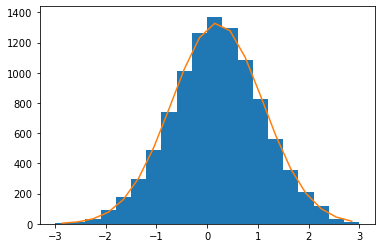

In [42]:

plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )
plt.plot( hist_bin_centers, model_pred )



plt.show

In [43]:
weight_sum

10007.44875255581

In [44]:
np.sum(unfolded_hist)

9992.694915812137

In [45]:
for bi in range( hist_nbins ) :
    diff = unfolded_hist[bi] - model_pred[bi]
    print(' %3d : x = %5.2f  model = %8.1f  hist = %8.1f  diff = %8.1f   sqrt(covii) = %8.1f' % 
          (bi, hist_bin_centers[bi], model_pred[bi], unfolded_hist[bi], diff, np.sqrt(hist_cov_mat[bi,bi]) ))

   0 : x = -2.85  model =      4.3  hist =      7.1  diff =      2.8   sqrt(covii) =      1.6
   1 : x = -2.55  model =     12.5  hist =     13.2  diff =      0.8   sqrt(covii) =      2.8
   2 : x = -2.25  model =     32.7  hist =     34.1  diff =      1.5   sqrt(covii) =      4.5
   3 : x = -1.95  model =     76.6  hist =     88.5  diff =     11.9   sqrt(covii) =      6.4
   4 : x = -1.65  model =    160.7  hist =    174.4  diff =     13.7   sqrt(covii) =      9.3
   5 : x = -1.35  model =    301.6  hist =    298.0  diff =     -3.6   sqrt(covii) =     12.8
   6 : x = -1.05  model =    506.5  hist =    488.5  diff =    -18.0   sqrt(covii) =     16.4
   7 : x = -0.75  model =    761.2  hist =    742.2  diff =    -19.1   sqrt(covii) =     20.4
   8 : x = -0.45  model =   1023.8  hist =   1013.5  diff =    -10.3   sqrt(covii) =     22.3
   9 : x = -0.15  model =   1232.1  hist =   1261.0  diff =     28.9   sqrt(covii) =     22.9
  10 : x =  0.15  model =   1326.8  hist =   1370.7  diff = 

In [46]:
dy = unfolded_hist - model_pred
    
cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)

cov_pinv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
dy_times_cov_pinv_times_dy =  np.sum( dy.T * cov_pinv_times_dy, axis=0)
    
this_chi2 = dy_times_cov_inv_times_dy

this_chi2_pinv = dy_times_cov_pinv_times_dy

print('\n\n chi2 = %10.3f, with pseudoinverse = %10.3f\n\n' % (this_chi2, this_chi2_pinv) )



 chi2 =   1471.393, with pseudoinverse =     25.105




In [47]:
dy

array([  2.80791554,   0.75449229,   1.45232628,  11.92217193,
        13.71495798,  -3.55217223, -18.00815938, -19.05715594,
       -10.31289162,  28.89342695,  43.93849226,  19.74251739,
       -15.4243091 , -25.27998714, -27.74898953,  -5.81537909,
         9.27834492,  16.66259472, -10.55572042,  -2.7743464 ])

In [48]:
cov_inv_times_dy

array([ -7.00572421,  27.5802001 , -25.32211656,  43.00176256,
       -35.0843364 ,  47.2930439 , -40.18172667,  49.84954909,
       -41.03772892,  51.01654915, -41.6704817 ,  51.07630231,
       -41.60456439,  49.92061658, -40.55952971,  49.3489928 ,
       -38.90696803,  41.46338872, -30.88047175,  28.4276326 ])

<function matplotlib.pyplot.show(close=None, block=None)>

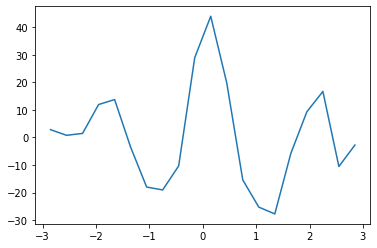

In [49]:
plt.plot( hist_bin_centers, dy )
plt.show

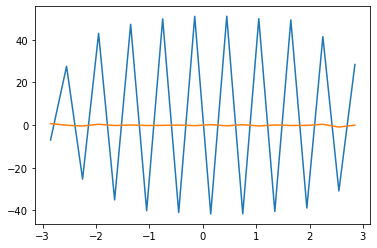

In [50]:
plt.plot( hist_bin_centers, cov_inv_times_dy )
plt.plot( hist_bin_centers, cov_pinv_times_dy )

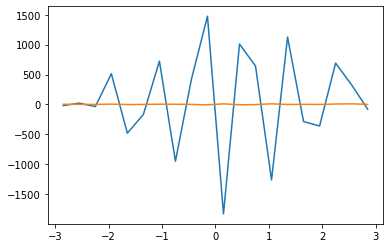

In [51]:
plt.plot( hist_bin_centers, dy.T * cov_inv_times_dy )
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )

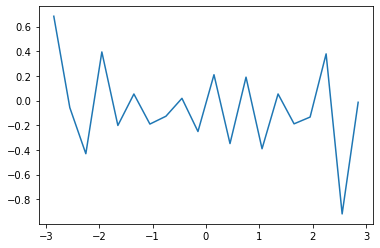

In [52]:
plt.plot( hist_bin_centers, cov_pinv_times_dy )

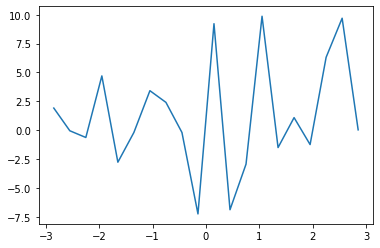

In [53]:
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )

In [54]:
n_scan_points = 10

scan_min = 0.0
scan_max = 0.4

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = scan_par_vals[si]
    model_sigma = 0.9
    model_cov = model_sigma * model_sigma

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.000  chi2 =          483.72,   diagonal chi2 =          896.88
 scan point   1  par   0.044  chi2 =          289.78,   diagonal chi2 =          536.89
 scan point   2  par   0.089  chi2 =          149.97,   diagonal chi2 =          275.60
 scan point   3  par   0.133  chi2 =           62.19,   diagonal chi2 =          109.34
 scan point   4  par   0.178  chi2 =           25.00,   diagonal chi2 =           35.53
 scan point   5  par   0.222  chi2 =           37.61,   diagonal chi2 =           52.71
 scan point   6  par   0.267  chi2 =           99.87,   diagonal chi2 =          160.44
 scan point   7  par   0.311  chi2 =          212.24,   diagonal chi2 =          359.30
 scan point   8  par   0.356  chi2 =          375.82,   diagonal chi2 =          650.89
 scan point   9  par   0.400  chi2 =          592.34,   diagonal chi2 =         1037.82


<function matplotlib.pyplot.show(close=None, block=None)>

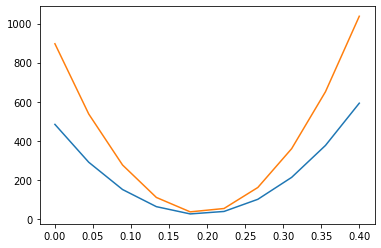

In [55]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [56]:
n_scan_points = 10

scan_min = 0.7
scan_max = 0.9

#scan_min = 0.78
#scan_max = 0.84

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )


for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = 0.2
    model_sigma = np.sqrt( scan_par_vals[si] )
    model_cov = scan_par_vals[si]

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )

    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy
    
    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
     
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.700  chi2 =          102.37,   diagonal chi2 =          198.56
 scan point   1  par   0.722  chi2 =           72.72,   diagonal chi2 =          136.90
 scan point   2  par   0.744  chi2 =           50.41,   diagonal chi2 =           90.04
 scan point   3  par   0.767  chi2 =           35.18,   diagonal chi2 =           57.41
 scan point   4  par   0.789  chi2 =           26.83,   diagonal chi2 =           38.49
 scan point   5  par   0.811  chi2 =           25.18,   diagonal chi2 =           32.83
 scan point   6  par   0.833  chi2 =           30.08,   diagonal chi2 =           40.02
 scan point   7  par   0.856  chi2 =           41.40,   diagonal chi2 =           59.70
 scan point   8  par   0.878  chi2 =           59.03,   diagonal chi2 =           91.54
 scan point   9  par   0.900  chi2 =           82.86,   diagonal chi2 =          135.23


<function matplotlib.pyplot.show(close=None, block=None)>

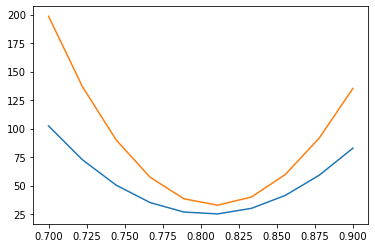

In [57]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [58]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

xMin = hist_xlow
xMax = hist_xhigh

In [59]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [60]:
# Initialize Minuit and set up fit:
theta = 1
mu = 0.2
sigma2 = 0.81
#fitType = 'bin center approximation'
#fitType = 'integral within bin'

parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
parname = ['theta', 'mu', 'sigma2']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
parfix  = [False, False, False]            # change to fix/free param.
parlim  = [(0.5, 1.5), (None, None), (0., None)]

chisq = ChiSquared(unfolded_hist, hist_bin_edges, hist_cov_pinv, fitType, 1)
chisq_diag = ChiSquared(unfolded_hist, hist_bin_edges, hist_cov_inv_diagonal, fitType, 1)


m = Minuit(chisq, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 1.0                      # errors from chi2 = chi2min + 1


m_diag = Minuit(chisq_diag, parin, name=parname)
m_diag.errors = parstep
m_diag.fixed = parfix
m_diag.limits = parlim
m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1



 setData:
  numVal:       9992.7  numBins = 20
  binLowEdge:   fitType: integral within bin
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


 setData:
  numVal:       9992.7  numBins = 20
  binLowEdge:   fitType: integral within bin
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


In [61]:
# do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
parhat = m.values                                 # max-likelihood estimates
sigma_parhat = m.errors                           # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

m_diag.migrad()                                        # minimize -logL
parhat_diag = m_diag.values                                 # max-likelihood estimates
sigma_parhat_diag = m_diag.errors                           # standard deviations
cov_diag = m_diag.covariance                                # covariance matrix
rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.




In [62]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:

        print(' %2d %-10s  =  %7.4f +/- %7.4f ,   diagonal cov result = %7.4f +/- %7.4f' %
              (i, m.parameters[i], parhat[i], sigma_parhat[i],
              parhat_diag[i], sigma_parhat_diag[i])
             )
            
            
            
print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not m.fixed[i]:
        for j in range(m.npar):
            if not m.fixed[j]:
                print(i, j, "{:9.6f}".format(cov[i,j]), "{:9.6f}".format(rho[i,j]))

# Retrieve minimized chi-squared, etc.
ndof = hist_nbins - m.nfit - 1           # for fixed numVal
chi2min = chisq(parhat)
print ("chi2min = ", chi2min, ",     ndof = ", ndof)
pval = chi2.sf(chi2min, ndof)
print ("pval = ", pval)

par index, name, estimate, standard deviation:
  0 theta       =   0.9964 +/-  0.0020 ,   diagonal cov result =  1.0022 +/-  0.0069
  1 mu          =   0.1890 +/-  0.0090 ,   diagonal cov result =  0.1915 +/-  0.0066
  2 sigma2      =   0.7904 +/-  0.0128 ,   diagonal cov result =  0.8023 +/-  0.0088

free par indices, covariance, correlation coeff.:
0 0  0.000004  1.000000
0 1 -0.000000 -0.024864
0 2  0.000008  0.319114
1 0 -0.000000 -0.024864
1 1  0.000081  1.000000
1 2  0.000002  0.013712
2 0  0.000008  0.319114
2 1  0.000002  0.013712
2 2  0.000163  1.000000
chi2min =  20.16364569424328 ,     ndof =  16
pval =  0.21294039685813598


In [63]:
n_scan_points = 40

scan_min = parhat[1] - 2*sigma_parhat[1]
scan_max = parhat[1] + 2*sigma_parhat[1]

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = scan_par_vals[si]
    model_sigma = 0.9
    model_cov = model_sigma * model_sigma

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.171  chi2 =           27.42,   diagonal chi2 =           40.83
 scan point   1  par   0.172  chi2 =           27.02,   diagonal chi2 =           39.98
 scan point   2  par   0.173  chi2 =           26.64,   diagonal chi2 =           39.17
 scan point   3  par   0.174  chi2 =           26.28,   diagonal chi2 =           38.40
 scan point   4  par   0.175  chi2 =           25.95,   diagonal chi2 =           37.67
 scan point   5  par   0.176  chi2 =           25.64,   diagonal chi2 =           36.98
 scan point   6  par   0.177  chi2 =           25.35,   diagonal chi2 =           36.32
 scan point   7  par   0.178  chi2 =           25.08,   diagonal chi2 =           35.71
 scan point   8  par   0.178  chi2 =           24.83,   diagonal chi2 =           35.13
 scan point   9  par   0.179  chi2 =           24.60,   diagonal chi2 =           34.60
 scan point  10  par   0.180  chi2 =           24.39,   diagonal chi2 =           34.10
 scan point  11  par   0.181  ch

<function matplotlib.pyplot.show(close=None, block=None)>

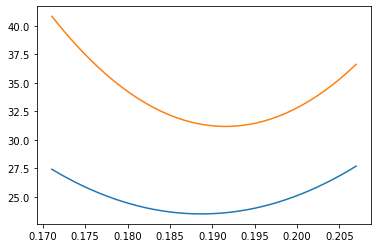

In [64]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [65]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals[si] < min_chi2 :
        min_chi2 = scan_chi2_vals[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals[si] - scan_chi2_vals[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals[si], dx, dchi2)
         )


  point for min chi2 :   19  val =  23.501
   0 :  x =   0.1711  chi2 =      27.42   dx = -0.0175  dchi2 =  3.9149
   1 :  x =   0.1720  chi2 =      27.02   dx = -0.0166  dchi2 =  3.5166
   2 :  x =   0.1729  chi2 =      26.64   dx = -0.0157  dchi2 =  3.1397
   3 :  x =   0.1738  chi2 =      26.28   dx = -0.0147  dchi2 =  2.7842
   4 :  x =   0.1747  chi2 =      25.95   dx = -0.0138  dchi2 =  2.4500
   5 :  x =   0.1757  chi2 =      25.64   dx = -0.0129  dchi2 =  2.1372
   6 :  x =   0.1766  chi2 =      25.35   dx = -0.0120  dchi2 =  1.8458
   7 :  x =   0.1775  chi2 =      25.08   dx = -0.0111  dchi2 =  1.5758
   8 :  x =   0.1784  chi2 =      24.83   dx = -0.0101  dchi2 =  1.3271
   9 :  x =   0.1793  chi2 =      24.60   dx = -0.0092  dchi2 =  1.0998
  10 :  x =   0.1803  chi2 =      24.39   dx = -0.0083  dchi2 =  0.8938
  11 :  x =   0.1812  chi2 =      24.21   dx = -0.0074  dchi2 =  0.7091
  12 :  x =   0.1821  chi2 =      24.05   dx = -0.0064  dchi2 =  0.5458
  13 :  x =   0.1830 

In [66]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals_diagonal[si] < min_chi2 :
        min_chi2 = scan_chi2_vals_diagonal[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals_diagonal[si] - scan_chi2_vals_diagonal[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals_diagonal[si], dx, dchi2)
         )


  point for min chi2 :   22  val =  31.170
   0 :  x =   0.1711  chi2 =      40.83   dx = -0.0203  dchi2 =  9.6604
   1 :  x =   0.1720  chi2 =      39.98   dx = -0.0193  dchi2 =  8.8116
   2 :  x =   0.1729  chi2 =      39.17   dx = -0.0184  dchi2 =  8.0019
   3 :  x =   0.1738  chi2 =      38.40   dx = -0.0175  dchi2 =  7.2312
   4 :  x =   0.1747  chi2 =      37.67   dx = -0.0166  dchi2 =  6.4996
   5 :  x =   0.1757  chi2 =      36.98   dx = -0.0157  dchi2 =  5.8070
   6 :  x =   0.1766  chi2 =      36.32   dx = -0.0147  dchi2 =  5.1535
   7 :  x =   0.1775  chi2 =      35.71   dx = -0.0138  dchi2 =  4.5390
   8 :  x =   0.1784  chi2 =      35.13   dx = -0.0129  dchi2 =  3.9635
   9 :  x =   0.1793  chi2 =      34.60   dx = -0.0120  dchi2 =  3.4271
  10 :  x =   0.1803  chi2 =      34.10   dx = -0.0111  dchi2 =  2.9296
  11 :  x =   0.1812  chi2 =      33.64   dx = -0.0101  dchi2 =  2.4712
  12 :  x =   0.1821  chi2 =      33.22   dx = -0.0092  dchi2 =  2.0517
  13 :  x =   0.1830 

In [67]:
n_scan_points = 40

scan_min = parhat[2] - 2*sigma_parhat[2]
scan_max = parhat[2] + 2*sigma_parhat[2]

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = 0.2
    model_cov = scan_par_vals[si]
    model_sigma = np.sqrt(model_cov)

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.765  chi2 =           36.18,   diagonal chi2 =           59.59
 scan point   1  par   0.766  chi2 =           35.46,   diagonal chi2 =           58.03
 scan point   2  par   0.767  chi2 =           34.77,   diagonal chi2 =           56.52
 scan point   3  par   0.769  chi2 =           34.10,   diagonal chi2 =           55.06
 scan point   4  par   0.770  chi2 =           33.46,   diagonal chi2 =           53.65
 scan point   5  par   0.771  chi2 =           32.84,   diagonal chi2 =           52.28
 scan point   6  par   0.773  chi2 =           32.25,   diagonal chi2 =           50.96
 scan point   7  par   0.774  chi2 =           31.68,   diagonal chi2 =           49.68
 scan point   8  par   0.775  chi2 =           31.13,   diagonal chi2 =           48.46
 scan point   9  par   0.777  chi2 =           30.60,   diagonal chi2 =           47.28
 scan point  10  par   0.778  chi2 =           30.10,   diagonal chi2 =           46.15
 scan point  11  par   0.779  ch

<function matplotlib.pyplot.show(close=None, block=None)>

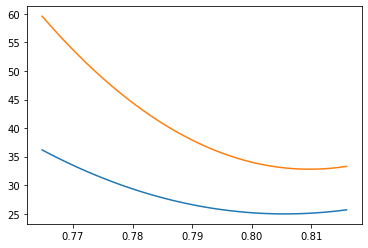

In [68]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [69]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals[si] < min_chi2 :
        min_chi2 = scan_chi2_vals[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals[si] - scan_chi2_vals[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals[si], dx, dchi2)
         )

  point for min chi2 :   31  val =  24.972
   0 :  x =   0.7648  chi2 =      36.18   dx = -0.0406  dchi2 = 11.2053
   1 :  x =   0.7661  chi2 =      35.46   dx = -0.0393  dchi2 = 10.4906
   2 :  x =   0.7674  chi2 =      34.77   dx = -0.0380  dchi2 =  9.7999
   3 :  x =   0.7688  chi2 =      34.10   dx = -0.0367  dchi2 =  9.1330
   4 :  x =   0.7701  chi2 =      33.46   dx = -0.0354  dchi2 =  8.4899
   5 :  x =   0.7714  chi2 =      32.84   dx = -0.0340  dchi2 =  7.8706
   6 :  x =   0.7727  chi2 =      32.25   dx = -0.0327  dchi2 =  7.2751
   7 :  x =   0.7740  chi2 =      31.68   dx = -0.0314  dchi2 =  6.7033
   8 :  x =   0.7753  chi2 =      31.13   dx = -0.0301  dchi2 =  6.1551
   9 :  x =   0.7766  chi2 =      30.60   dx = -0.0288  dchi2 =  5.6306
  10 :  x =   0.7779  chi2 =      30.10   dx = -0.0275  dchi2 =  5.1297
  11 :  x =   0.7792  chi2 =      29.62   dx = -0.0262  dchi2 =  4.6523
  12 :  x =   0.7805  chi2 =      29.17   dx = -0.0249  dchi2 =  4.1985
  13 :  x =   0.7818 

In [70]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals_diagonal[si] < min_chi2 :
        min_chi2 = scan_chi2_vals_diagonal[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals_diagonal[si] - scan_chi2_vals_diagonal[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals_diagonal[si], dx, dchi2)
         )


  point for min chi2 :   34  val =  32.802
   0 :  x =   0.7648  chi2 =      59.59   dx = -0.0445  dchi2 = 26.7889
   1 :  x =   0.7661  chi2 =      58.03   dx = -0.0432  dchi2 = 25.2312
   2 :  x =   0.7674  chi2 =      56.52   dx = -0.0419  dchi2 = 23.7212
   3 :  x =   0.7688  chi2 =      55.06   dx = -0.0406  dchi2 = 22.2588
   4 :  x =   0.7701  chi2 =      53.65   dx = -0.0393  dchi2 = 20.8438
   5 :  x =   0.7714  chi2 =      52.28   dx = -0.0380  dchi2 = 19.4761
   6 :  x =   0.7727  chi2 =      50.96   dx = -0.0367  dchi2 = 18.1557
   7 :  x =   0.7740  chi2 =      49.68   dx = -0.0354  dchi2 = 16.8825
   8 :  x =   0.7753  chi2 =      48.46   dx = -0.0340  dchi2 = 15.6563
   9 :  x =   0.7766  chi2 =      47.28   dx = -0.0327  dchi2 = 14.4771
  10 :  x =   0.7779  chi2 =      46.15   dx = -0.0314  dchi2 = 13.3448
  11 :  x =   0.7792  chi2 =      45.06   dx = -0.0301  dchi2 = 12.2592
  12 :  x =   0.7805  chi2 =      44.02   dx = -0.0288  dchi2 = 11.2204
  13 :  x =   0.7818 

In [71]:
boot_hist_content.shape

(500, 20)

In [72]:
len(boot_hist_content)

500

In [73]:

chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



for si in range( len(boot_hist_content) ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.2045 +/-   0.0089  (  0.2060 +/-   0.0066)    sig2   0.8385 +/-   0.0130  (  0.8394 +/-   0.0087)
   1 : mu   0.1971 +/-   0.0089  (  0.1967 +/-   0.0066)    sig2   0.8123 +/-   0.0128  (  0.8087 +/-   0.0086)
   2 : mu   0.1926 +/-   0.0089  (  0.1930 +/-   0.0066)    sig2   0.8080 +/-   0.0129  (  0.8040 +/-   0.0087)
   3 : mu   0.1941 +/-   0.0090  (  0.1956 +/-   0.0066)    sig2   0.8120 +/-   0.0127  (  0.8217 +/-   0.0087)
   4 : mu   0.1993 +/-   0.0090  (  0.1999 +/-   0.0066)    sig2   0.8120 +/-   0.0130  (  0.8157 +/-   0.0088)
   5 : mu   0.2157 +/-   0.0089  (  0.2168 +/-   0.0066)    sig2   0.8292 +/-   0.0128  (  0.8287 +/-   0.0086)
   6 : mu   0.2028 +/-   0.0089  (  0.2026 +/-   0.0066)    sig2   0.8040 +/-   0.0128  (  0.8034 +/-   0.0087)
   7 : mu   0.2103 +/-   0.0089  (  0.2110 +/-   0.0066)    sig2   0.8096 +/-   0.0132  (  0.8087 +/-   0.0089)
   8 : mu   0.1870 +/-   0.0090  (  0.1880 +/-   0.0066)    sig2   0.7920 +/-   0.0127  (  0.8046 +/-   

  74 : mu   0.2031 +/-   0.0090  (  0.2037 +/-   0.0066)    sig2   0.8005 +/-   0.0128  (  0.8074 +/-   0.0088)
  75 : mu   0.1899 +/-   0.0090  (  0.1909 +/-   0.0066)    sig2   0.8056 +/-   0.0127  (  0.8139 +/-   0.0087)
  76 : mu   0.2032 +/-   0.0090  (  0.2017 +/-   0.0066)    sig2   0.8142 +/-   0.0129  (  0.8227 +/-   0.0088)
  77 : mu   0.2028 +/-   0.0089  (  0.2044 +/-   0.0066)    sig2   0.7940 +/-   0.0125  (  0.7940 +/-   0.0085)
  78 : mu   0.1966 +/-   0.0089  (  0.1998 +/-   0.0066)    sig2   0.8355 +/-   0.0131  (  0.8354 +/-   0.0087)
  79 : mu   0.1997 +/-   0.0089  (  0.2002 +/-   0.0066)    sig2   0.8294 +/-   0.0130  (  0.8296 +/-   0.0088)
  80 : mu   0.2051 +/-   0.0090  (  0.2039 +/-   0.0066)    sig2   0.8096 +/-   0.0131  (  0.8152 +/-   0.0089)
  81 : mu   0.1930 +/-   0.0090  (  0.1934 +/-   0.0066)    sig2   0.7803 +/-   0.0126  (  0.7868 +/-   0.0086)
  82 : mu   0.1784 +/-   0.0089  (  0.1787 +/-   0.0066)    sig2   0.8249 +/-   0.0130  (  0.8144 +/-   

 162 : mu   0.1973 +/-   0.0089  (  0.1995 +/-   0.0066)    sig2   0.8147 +/-   0.0128  (  0.8196 +/-   0.0087)
 163 : mu   0.2058 +/-   0.0089  (  0.2059 +/-   0.0066)    sig2   0.8230 +/-   0.0128  (  0.8203 +/-   0.0086)
 164 : mu   0.2077 +/-   0.0090  (  0.2065 +/-   0.0066)    sig2   0.8174 +/-   0.0130  (  0.8193 +/-   0.0087)
 165 : mu   0.2110 +/-   0.0090  (  0.2082 +/-   0.0066)    sig2   0.7904 +/-   0.0124  (  0.7993 +/-   0.0085)
 166 : mu   0.1988 +/-   0.0090  (  0.1956 +/-   0.0066)    sig2   0.8055 +/-   0.0129  (  0.8126 +/-   0.0088)
 167 : mu   0.1978 +/-   0.0090  (  0.1992 +/-   0.0066)    sig2   0.8049 +/-   0.0129  (  0.8091 +/-   0.0087)
 168 : mu   0.1902 +/-   0.0090  (  0.1909 +/-   0.0066)    sig2   0.7988 +/-   0.0127  (  0.8064 +/-   0.0087)
 169 : mu   0.1883 +/-   0.0089  (  0.1908 +/-   0.0066)    sig2   0.8194 +/-   0.0127  (  0.8185 +/-   0.0086)
 170 : mu   0.1919 +/-   0.0090  (  0.1917 +/-   0.0066)    sig2   0.7898 +/-   0.0127  (  0.7946 +/-   

 247 : mu   0.2063 +/-   0.0089  (  0.2078 +/-   0.0066)    sig2   0.8035 +/-   0.0127  (  0.8056 +/-   0.0086)
 248 : mu   0.1848 +/-   0.0089  (  0.1841 +/-   0.0066)    sig2   0.8117 +/-   0.0128  (  0.8129 +/-   0.0086)
 249 : mu   0.1862 +/-   0.0090  (  0.1888 +/-   0.0066)    sig2   0.7984 +/-   0.0128  (  0.8057 +/-   0.0088)
 250 : mu   0.1991 +/-   0.0090  (  0.2005 +/-   0.0066)    sig2   0.8237 +/-   0.0130  (  0.8366 +/-   0.0089)
 251 : mu   0.1922 +/-   0.0089  (  0.1947 +/-   0.0066)    sig2   0.8016 +/-   0.0128  (  0.8011 +/-   0.0087)
 252 : mu   0.2067 +/-   0.0090  (  0.2079 +/-   0.0066)    sig2   0.8049 +/-   0.0128  (  0.8207 +/-   0.0088)
 253 : mu   0.2062 +/-   0.0090  (  0.2091 +/-   0.0066)    sig2   0.7840 +/-   0.0125  (  0.7899 +/-   0.0086)
 254 : mu   0.1896 +/-   0.0089  (  0.1924 +/-   0.0066)    sig2   0.8235 +/-   0.0130  (  0.8239 +/-   0.0087)
 255 : mu   0.1777 +/-   0.0089  (  0.1752 +/-   0.0066)    sig2   0.7931 +/-   0.0126  (  0.7917 +/-   

 329 : mu   0.2026 +/-   0.0089  (  0.2051 +/-   0.0066)    sig2   0.8193 +/-   0.0127  (  0.8203 +/-   0.0086)
 330 : mu   0.2060 +/-   0.0090  (  0.2024 +/-   0.0066)    sig2   0.8362 +/-   0.0131  (  0.8392 +/-   0.0088)
 331 : mu   0.1822 +/-   0.0090  (  0.1828 +/-   0.0066)    sig2   0.8017 +/-   0.0129  (  0.8123 +/-   0.0088)
 332 : mu   0.1940 +/-   0.0090  (  0.1928 +/-   0.0066)    sig2   0.8263 +/-   0.0129  (  0.8288 +/-   0.0086)
 333 : mu   0.2129 +/-   0.0090  (  0.2148 +/-   0.0066)    sig2   0.8215 +/-   0.0131  (  0.8258 +/-   0.0088)
 334 : mu   0.2045 +/-   0.0090  (  0.2048 +/-   0.0066)    sig2   0.8148 +/-   0.0126  (  0.8219 +/-   0.0086)
 335 : mu   0.2020 +/-   0.0089  (  0.2016 +/-   0.0066)    sig2   0.8097 +/-   0.0129  (  0.8090 +/-   0.0087)
 336 : mu   0.1941 +/-   0.0089  (  0.1897 +/-   0.0066)    sig2   0.8064 +/-   0.0129  (  0.8034 +/-   0.0087)
 337 : mu   0.2062 +/-   0.0089  (  0.2064 +/-   0.0066)    sig2   0.8315 +/-   0.0131  (  0.8340 +/-   

 418 : mu   0.1993 +/-   0.0090  (  0.2016 +/-   0.0066)    sig2   0.8095 +/-   0.0130  (  0.8135 +/-   0.0088)
 419 : mu   0.2013 +/-   0.0089  (  0.2010 +/-   0.0066)    sig2   0.8180 +/-   0.0129  (  0.8135 +/-   0.0086)
 420 : mu   0.1939 +/-   0.0090  (  0.1920 +/-   0.0066)    sig2   0.7994 +/-   0.0126  (  0.8032 +/-   0.0086)
 421 : mu   0.1832 +/-   0.0090  (  0.1820 +/-   0.0066)    sig2   0.8185 +/-   0.0127  (  0.8258 +/-   0.0086)
 422 : mu   0.1968 +/-   0.0090  (  0.1941 +/-   0.0066)    sig2   0.7979 +/-   0.0128  (  0.8030 +/-   0.0088)
 423 : mu   0.2075 +/-   0.0090  (  0.2052 +/-   0.0066)    sig2   0.7989 +/-   0.0127  (  0.8031 +/-   0.0086)
 424 : mu   0.1955 +/-   0.0090  (  0.1953 +/-   0.0066)    sig2   0.7999 +/-   0.0128  (  0.8147 +/-   0.0088)
 425 : mu   0.2099 +/-   0.0089  (  0.2081 +/-   0.0066)    sig2   0.8251 +/-   0.0130  (  0.8228 +/-   0.0087)
 426 : mu   0.2142 +/-   0.0090  (  0.2130 +/-   0.0066)    sig2   0.7950 +/-   0.0127  (  0.8025 +/-   

<function matplotlib.pyplot.show(close=None, block=None)>

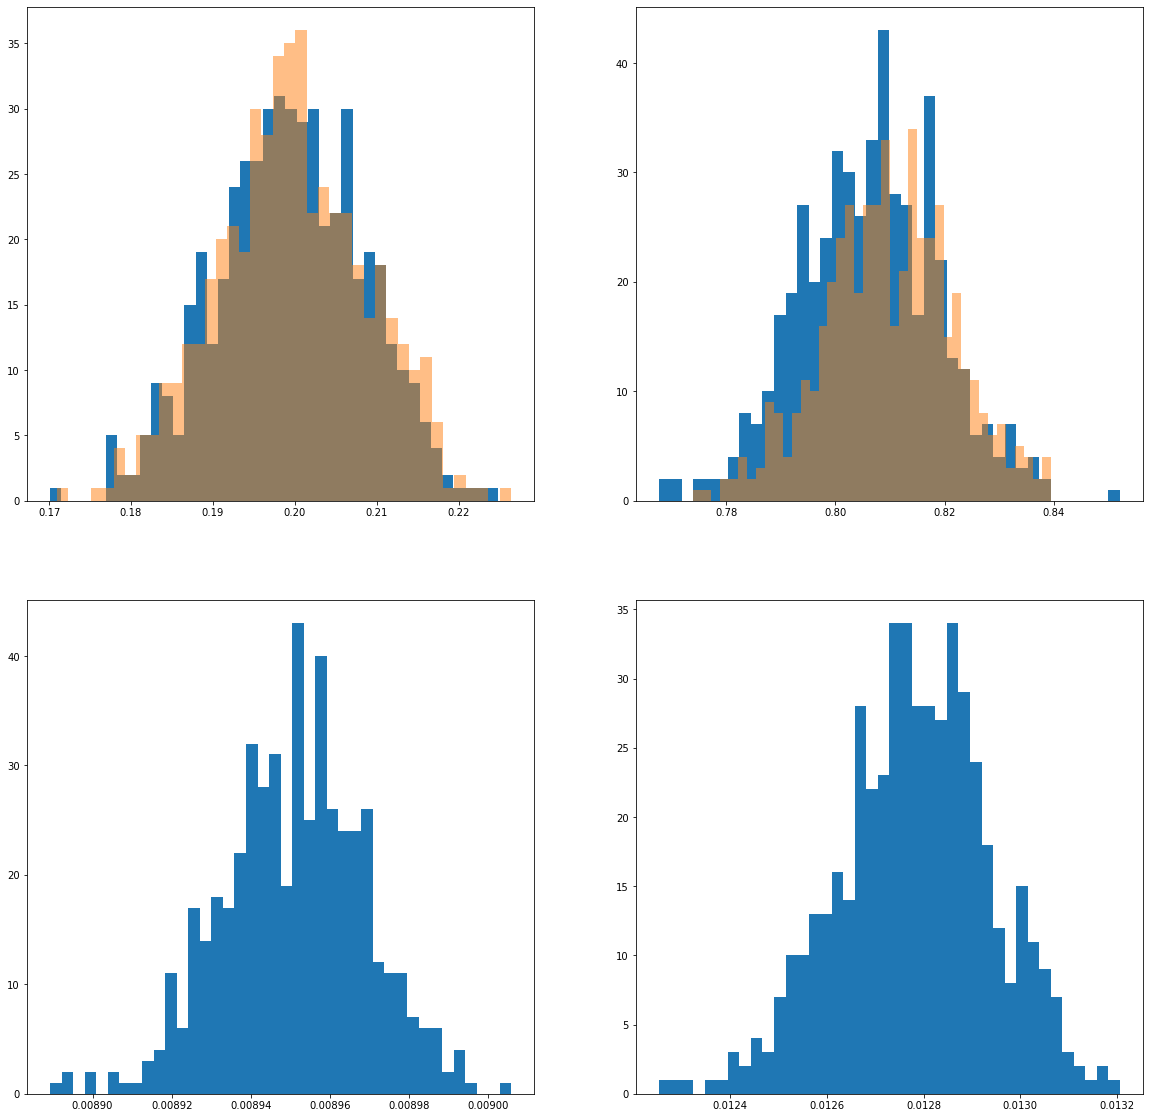

In [74]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [75]:



mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')






 mean:  0.1994, rms  0.0090, mean fit err  0.0090  |  diag. chi2 fit    0.1997, rms  0.0091, mean fit err  0.0066
 sig2:  0.8062, rms  0.0127, mean fit err  0.0128  |  diag. chi2 fit    0.8098, rms  0.0119, mean fit err  0.0087





<function matplotlib.pyplot.show(close=None, block=None)>

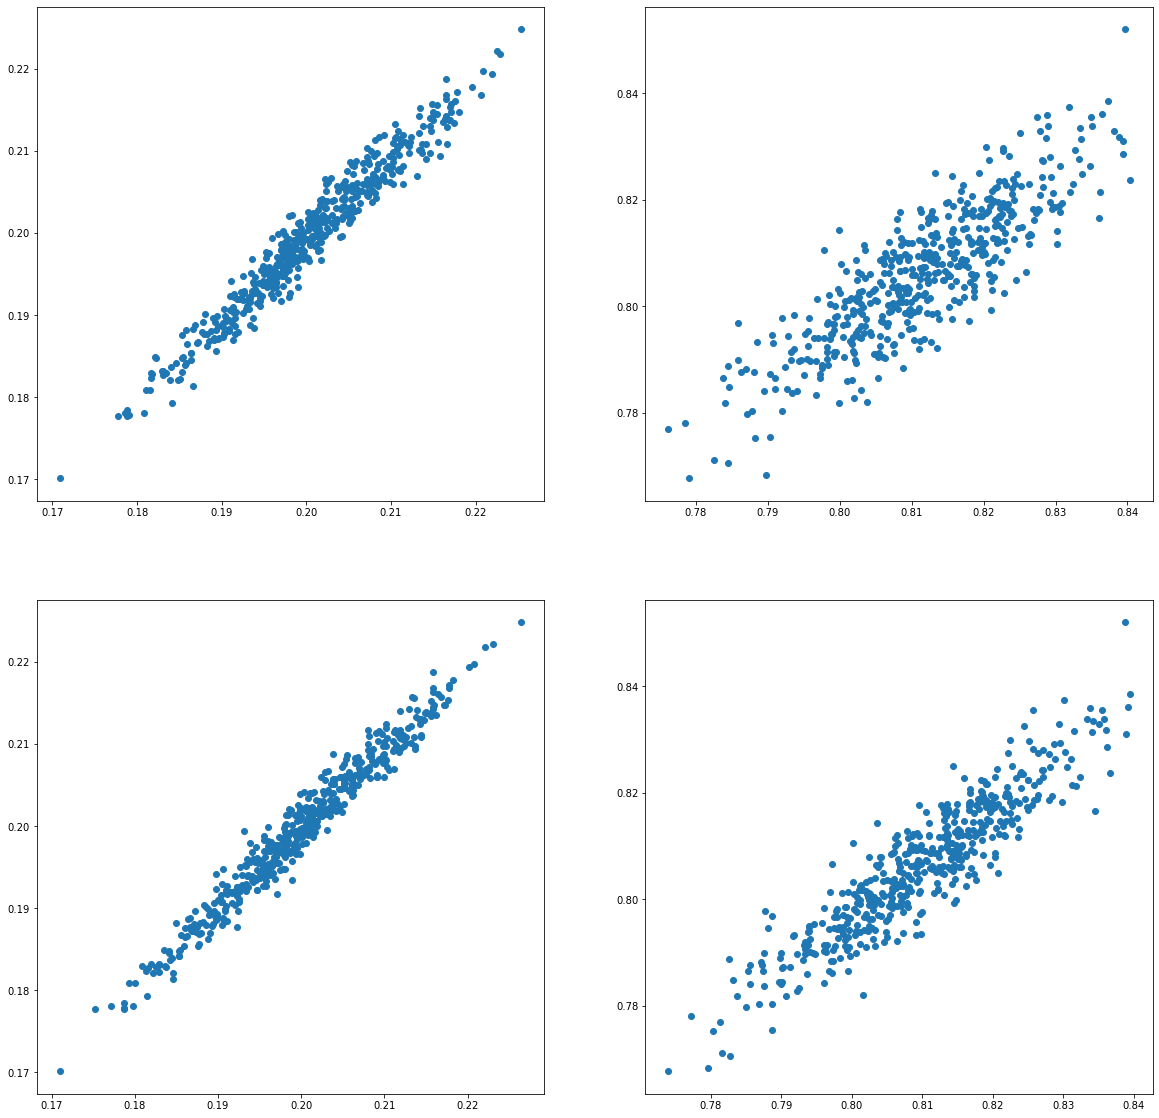

In [76]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].scatter( simple_calc_mean, chi2_fit_mu_val )
ax[0][1].scatter( simple_calc_cov, chi2_fit_sig2_val )

ax[1][0].scatter( chi2_fit_diag_mu_val, chi2_fit_mu_val )
ax[1][1].scatter( chi2_fit_diag_sig2_val, chi2_fit_sig2_val )

plt.show